<a href="https://colab.research.google.com/github/nhuang37/untrain_MPNN/blob/main/Finegrain_MPNN_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/JHU/Untrain_GNN/

/content/drive/MyDrive/JHU/Untrain_GNN


In [3]:
!pip install scipy==1.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import numpy as np
import networkx as nx
import copy
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from collections import Counter
from networkx.generators.nonisomorphic_trees import nonisomorphic_trees
import os
from sympy.utilities.iterables import multiset_permutations
import itertools
from itertools import permutations
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
np.set_printoptions(precision=4, suppress=True)

import distance #credit to Jan
#from gnn_architectures import GIN, GINE, GC


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN

from torch_geometric.utils.convert import from_networkx, from_scipy_sparse_matrix
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader

from torch_geometric.nn import GINConv, GraphConv, GCNConv, global_add_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.inits import reset


In [7]:
seed = 406
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [8]:
# Taken from https://github.com/rusty1s/pytorch_geometric/blob/master/benchmark/kernel/gin.py.
class GIN_rep(torch.nn.Module):
    def __init__(self, input_dim, num_layers, hidden, untrain):
        super(GIN_rep, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(input_dim, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
            train_eps=True)

        self.untrain = untrain

        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                    train_eps=True))


    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

        if self.untrain:
            for param in self.conv1.parameters():
                param.requires_grad = False

            for conv in self.convs:
                for param in conv.parameters():
                    param.requires_grad = False

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)

        x = global_add_pool(x, batch)

        return x

    def __repr__(self):
        return self.__class__.__name__


In [9]:
class GC_rep(torch.nn.Module):
    def __init__(self, input_dim, num_layers, hidden, untrain):
        super(GC_rep, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GraphConv(hidden, hidden))

        self.untrain = untrain

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

        if self.untrain:
            for param in self.conv1.parameters():
                param.requires_grad = False

            for conv in self.convs:
                for param in conv.parameters():
                    param.requires_grad = False

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)

        for conv in self.convs:
            x = conv(x, edge_index)

        x = global_add_pool(x, batch)

        return x

    def __repr__(self):
        return self.__class__.__name__

In [14]:
#config
def generate_graphs(num_G = 10, n = 30, p = 0.5, q = 0.1, seed=0):
  '''
  Simulate graphs: 
  '''
  graph_set = []
  qs = np.linspace(q, p, num_G) #generate a sequence of SBM graphs tending to ER graph
  for i in range(num_G):
    graph_set.append(
          nx.stochastic_block_model([n//2, n//2], [[p,q],[q,p]], seed=i)
      )
  return graph_set
  

In [28]:
num_G = 50
n = 30
p = 0.5
q = 0.1
graphs = generate_graphs(num_G, n, p, q)


In [29]:
def compute_seq_distance(graph_set, metric="Wasserstein"):
  '''
  Compute the distance metric of the graph set w.r.t last element
  Return a list of distance with length = |graph_set|
  '''
  num_G = len(graph_set)
  seq_dist = np.zeros(num_G)
  for i in range(num_G-1):
    if metric == "Wasserstein":
      dist = distance.demoRun(graph_set[i], graph_set[-1],"Wasserstein distance", "flow, at most 3 iterations after refinement", 
                              distance.wassersteinMinCostFlow, convIterationBound = 3)
    elif metric == "Euclidean":
      assert type(graph_set[0]) == torch.Tensor, "must pass in graph Euclidean embedding!"
      dist = torch.linalg.vector_norm(graph_set[i] - graph_set[-1])
    else:
      NotImplementedError
    seq_dist[i] = dist

  return seq_dist

In [30]:
graph_dist = compute_seq_distance(graphs)

Wasserstein distance: 	0.05895 [11.77 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.02947 [15.45 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.04594 [11.79 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.04277 [11.73 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.03673 [15.15 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.03193 [12.23 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.03048 [12.42 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.01955 [15.92 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.03410 [12.10 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.03086 [15.76 seconds] (flow, at most 3 iterations after refinement)
Wasserstein distance: 	0.04983 [13.41 seconds] (flow, at most 3 iterat

In [31]:
#save
pickle.dump((graphs, graph_dist), open("graph_seq_dist_SBM.pkl", "wb"))

In [32]:
##for MPNN embeddings
n = 30
#constant node features
x = torch.ones((n, 1), dtype=torch.float)
#data loader
graphs_pyg = []
for G in graphs:
  A = nx.to_scipy_sparse_array(G)
  graphs_pyg.append(Data(x=x, edge_index=from_scipy_sparse_matrix(A)[0]))

graph_loader = DataLoader(graphs_pyg, batch_size=num_G)


In [33]:
torch.manual_seed(0)

# Set device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#untrain GNN
input_dim = 1 
hid_dim = 64
num_layers = 3
GIN_block = GIN_rep(input_dim, num_layers, hid_dim, untrain=True)#.to(device)
GC_block = GC_rep(input_dim, num_layers, hid_dim, untrain=True)

In [34]:
#forward pass: obtain untrained graph embedding
MPNN_embeds = {'GIN':[], 'GC':[]}
for data in graph_loader:
  #data = data.to(device)
  MPNN_embeds['GIN'].append(GIN_block(data))
  MPNN_embeds['GC'].append(GC_block(data))

In [35]:
GIN_dist = compute_seq_distance(MPNN_embeds['GIN'][0], metric="Euclidean")
GC_dist = compute_seq_distance(MPNN_embeds['GC'][0], metric="Euclidean")

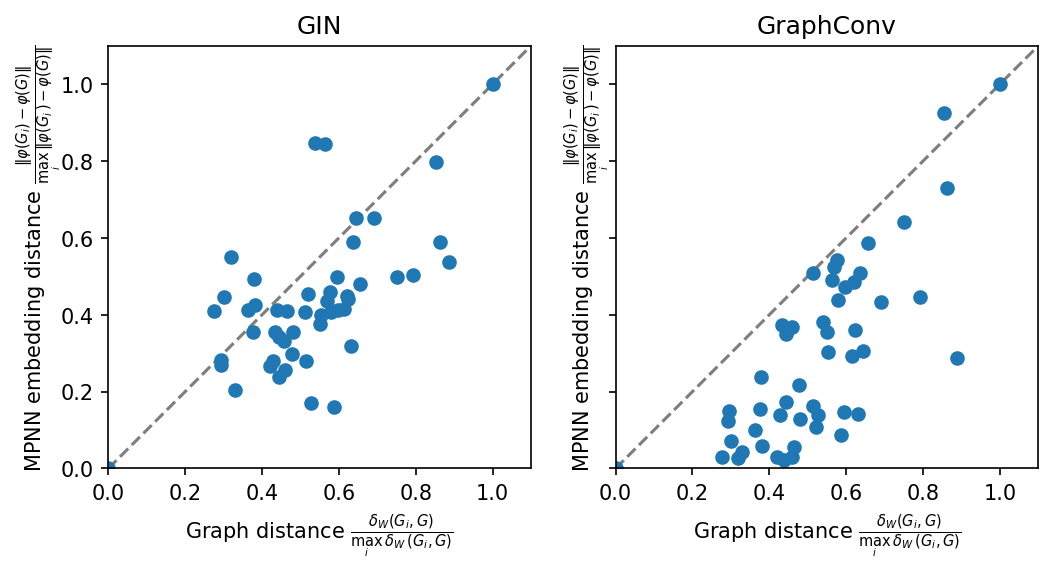

In [36]:

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,4), dpi=150)
axs[0].scatter(graph_dist/graph_dist.max(), GIN_dist/GIN_dist.max())
axs[0].set_title("GIN")

axs[1].scatter(graph_dist/graph_dist.max(), GC_dist/GC_dist.max())
axs[1].set_title("GraphConv")

lims = [0, 1.1]

for ax in axs:
  ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlabel(r"Graph distance $\frac{\delta_W(G_i, G)}{\max_{i} \, \delta_W(G_i, G)}$", ha='center')
  ax.set_ylabel(r"MPNN embedding distance $\frac{\| \varphi(G_i) - \varphi(G) \|}{\max_{i} \, \| \varphi(G_i) - \varphi(G) \|}$", va='center', rotation='vertical', labelpad=10)

plt.xlim(lims[0],lims[1])
plt.ylim(lims[0],lims[1])

#plt.xlabel()
#plt.ylabel()
#fig.tight_layout()
plt.show()
#len(pair_dist[upper_mask])